# Multilabel Digit Classification
This notebook will focus on analyzing and classifying digits based on largeness and whether they are even using the MNIST digit dataset. This notebook provides a complete data science workflow that covers all the necessary steps, from data exploration to deployment. <br>
## Table of Contents
1. [Framing and Description of the Problem](#Framing-and-Description-of-the-Problem)
2. [Obtaining the Data](#Obtaining-the-Data)
3. [Exploring the Data](#Exploring-the-Data)
4. [Data Preprocessing](#Data-Preprocessing)
5. [Model Training and Selection](#Model-Training-and-Selection)
6. [Model fine-tuning](#Model-fine-tuning)
7. [Save the model](#Save-the-model)

# Framing and Description of the Problem
The MNIST dataset contains features of 28x28 digit images and our goal is to predict which digit we are looking at. From this information we can conclude that this is a classification problem that requires only numerical preprocessing.

# Obtaining the Data
We can use sklearn's `fetch_openml` method from `sklearn.datasets` to fetch the dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

C:\Users\Nifdi Guliyev\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Exploring the Data

In [2]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [3]:
mnist.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X, y = mnist.data, mnist.target

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
X.shape

(70000, 784)

In [14]:
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

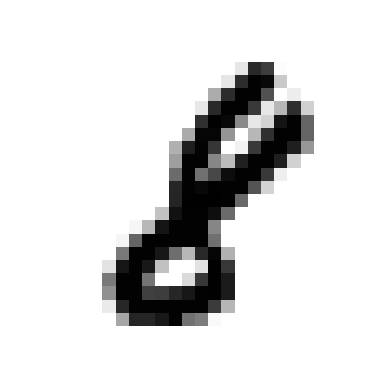

In [19]:
digit = X[10001]
plot_image(digit)
plt.show()

# Data Preprocessing
Feature values of images range from 0(black) to 255(white) and we can scale them to 0 and 1 to make the model work faster. Clearly, our upper and lower bounds are known and the data does not follow a normal distribution; therefore we will be using `MinMaxScaler`.

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [24]:
print(f"Maximum feature value: {X[0].max()}")
print(f"Minimum feature value: {X[0].min()}")

Maximum feature value: 1.0
Minimum feature value: 0.0


In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape : (10000, 784)
y_test shape : (10000,)


To create the multilabel system we need to convert the values of the dataset. We will only manipulate the target dataset (y_train, and y_test).

In [33]:
import numpy as np
y_train_large = (y_train >= '7')
y_train_even = (y_train.astype('int8') % 2 == 0)
y_multilabel = np.c_[y_train_large, y_train_even] # concatonates the labels

In [70]:
print(y_train[4])
print(y_multilabel[4]) # Gives out False (not large) and True (even)

9
[ True False]


# Model Training and Selection

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_pipeline = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("knn", KNeighborsClassifier())
    ])

knn_pipeline.fit(X_train, y_multilabel)

Pipeline(steps=[('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])

In [85]:
digit=10
print(f"Target Value            : {y_train[digit]}")
print(f"Predicted Value         : {np.squeeze(knn_pipeline.predict([X_train[digit]]))} (Not a large and not even)")
print(f"Multilabel Target Value : {y_multilabel[digit]} (Not a large and not even)")

Target Value            : 3
Predicted Value         : [False False] (Not a large and not even)
Multilabel Target Value : [False False] (Not a large and not even)


In [62]:
from sklearn.model_selection import cross_val_predict
y_train_knn_pred = cross_val_predict(knn_pipeline, X_train, y_multilabel, cv=3)

In [63]:
from sklearn.metrics import f1_score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9759631907980348

# Model fine-tuning

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'knn__weights': ["uniform", "distance"], 'knn__n_neighbors': [3,4,5,6,7,8]}]

grid_cv = GridSearchCV(knn_pipeline, param_grid, cv=5)
grid_cv.fit(X_train, y_multilabel)

grid_cv.best_params_

{'knn__n_neighbors': 4, 'knn__weights': 'distance'}

In [96]:
grid_cv.best_score_

0.9779

In [97]:
final_model = grid_cv

# Save the model

In [99]:
import joblib

joblib.dump(final_model, "models/multilabel_digit_classifier.pkl")

['models/multilabel_digit_classifier.pkl']

In [100]:
y_test_large = (y_test >= '7')
y_test_even = (y_test.astype('int8') % 2 == 0)
y_multilabel = np.c_[y_test_large, y_test_even] # concatonates the labels

In [105]:
final_model_reloaded = joblib.load("models/multilabel_digit_classifier.pkl")

index = 0
pred = final_model_reloaded.predict(X_test)
print(f"Numerical Value : {y_test[index]}")
print(f"Predicted value : {pred[index]}")
print(f"Actual value    : {y_multilabel[index]}")

Numerical Value : 7
Predicted value : [ True False] 
Actual value    : [ True False]
